# Licenses

In [1]:
# include common code and config
# selected_pi = 10
%run PIQM_Bootstrap.ipynb

{'pi': 'PI12', 'id': 12, 'start': '2021-09-16T00:00:00Z', 'started': '2021-09-16', 'finish': '2021-12-16T23:59:59Z'}


In [2]:
query_api = client.query_api()


def highlight_rows(s):
    if 'other' in s.Names or 'unknown' in s.Names:
        return ['background-color: pink'] * s.size
    else:
        return [''] * s.size

df_licenses = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: 2021-03-18T23:59:59Z) 
        |> filter(fn: (r) => r._measurement == "projects" and r._field == "last_coverage") 
        |> drop(columns:["pipeline_last_run_status", "id", "project", "got_rtd", "got_coverage", "got_linting", "got_tests", "_measurement", "_field"]) 
        |> group(columns: ["license"]) |> count()""")
df_licenses['approval'] = "Un Approved"
df_licenses['total'] = 'Total'
df_licenses['plainnames'] = df_licenses['license']
df_licenses.loc[df_licenses.license.isin(['other','no-license']),'plainnames'] = "unknown"
df_licenses.loc[df_licenses.license.isin(['bsd-3-clause','apache-2.0']),'approval'] = "Approved"
df_licenses['names'] = df_licenses['license'].astype(str) + " ("+ df_licenses['_value'].astype(str)+")"
df_licenses_tab = df_licenses[["names", "_value"]].rename(columns={"_value": "count", "names": "Names"})\
    .sort_values(["count"], ascending=False)
df_licenses_tab.style.hide_index()\
    .set_properties(subset=['Names'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .apply(highlight_rows, axis = 1)\
    .set_caption('SKA License Usage')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])

#     .highlight_max(color='pink', subset=['count'])\
#     .apply(highlight_max, subset=['count'])\


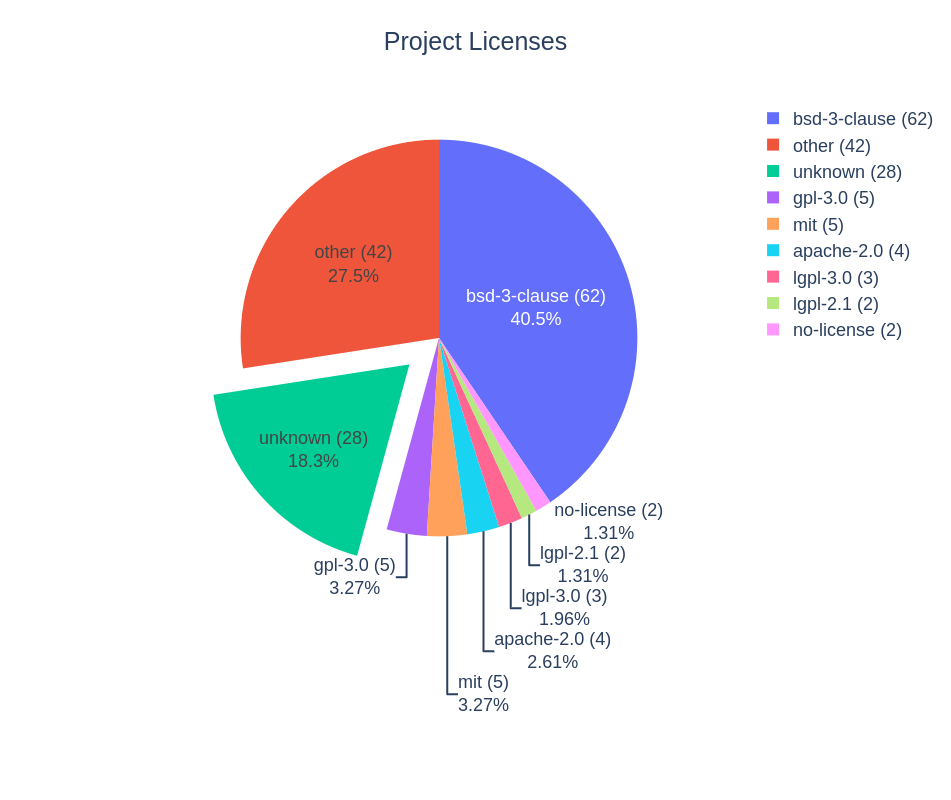

In [3]:
# https://plotly.com/python/discrete-color/
fig = px.pie(df_licenses_tab, values='count', names='Names', title='Project Licenses')
fig.update_traces(hoverinfo='value+label+percent', textinfo='percent+label', textfont_size=18, pull=[0, 0.0, 0.2, 0])
fig.update_layout(barmode='stack', yaxis=dict(
        titlefont_size=16,
        tickfont_size=14,
    ), height=800, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',     font=dict(
        size=18,
    ))
# , showlegend=False)
fig.show()

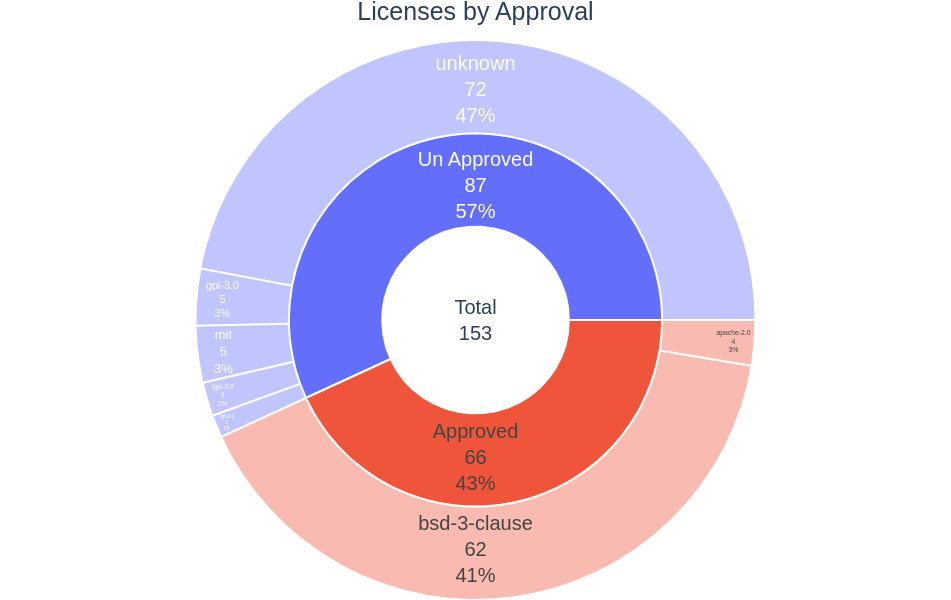

In [4]:
import plotly.express as px
df_licenses = df_licenses.rename(columns={"_value": "Count", "plainnames": "Names", "approval": "Approval", "total": "Total"})
fig = px.sunburst(df_licenses, 
                  title="Licenses by Approval",
                  height=600,
                  path=['Total', 'Approval', 'Names'], 
                  values='Count', 
                  branchvalues="total",
#                  color_discrete_map={'Total': 'white'}
                 )


fig.update_traces(textinfo='label+value+percent entry', 
                  textfont_size=20, 
                  insidetextorientation='horizontal',
                  leaf={'opacity': 0.4},
                  marker={'line': {'width': [2 for i in range(len(df_licenses))], 'color': '#fff'}},
                 )

fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=18,),
                  margin = dict(t=40, l=0, r=0, b=0),)

fig.show()